# Computing Assignment 2 - Math 578
## Matthew King-Roskamp
## Student Number: 260976649

In [1]:
# Standard Preamble, importing necessary packages
import numpy as np;
import matplotlib.pyplot as pl;

# Part 1: QR factorization.
Here, we implement a function that computes a QR factorization of a given matrix $A$. We do this via householder reflections. We choose to store the reflectors $v_{k}$ implicitly in a matrix VMat. This will serve to make certain computations faster, at the tradeoff that we must construct the matrix $Q$ explicitly at the end of the computation. Note to enfore uniqueness, we postprocess our computed QR factorization $\tilde{Q},\tilde{R}$: 
$$ A = \tilde{Q}DD\tilde{R} = QR,$$
where $D = \text{sign(diag}(R)$ is the diagonal matrix of the sign of the diagonal of $\tilde{R}$. This gives that $R = D\tilde{R}$ has strictly non-negative diagonal entries; and thus our QR factorization is unique.

We note that these algorithms are standard, and can be found (e.g.) in Treffethen and Bau. Thus, we comment only sparingly.

In [2]:
def QRFactorize(A):
    n = A.shape[0];
    R = np.copy(A);
    VMat = np.zeros((n,n))
    
    for k in range(n):
        # Construct Householder reflector
        e = np.zeros(n-k);
        e[0] = 1;
        x = R[k:n,k];
        v = np.sign(x[0])*np.linalg.norm(x)*e + x;
        v = v/np.linalg.norm(v);
        
        # Apply reflector to update matrix R
        R[k:n,k:n] = R[k:n,k:n] - 2*np.matmul(np.outer(v,v),R[k:n,k:n]);
        
        # Implicitly store Q via the reflectors v 
        VMat[0:n-k,k] = v;
        
    # Enforce the diagonal of R is non-negarive 
    D = np.sign(np.diag(R));
    R = np.matmul(np.diag(D),R);
    
    return [R,VMat,D];

def Qmultiply(b,VMat):
    # For when we wish to multiply by Q, use the matrix of reflectors.
    n = b.shape[0];
    res = np.copy(b);
    for k in range(n-1,-1,-1):
        vk = VMat[0:n-k,k];
        res[k:n] = res[k:n] - 2*np.matmul(np.outer(vk,vk),res[k:n]);

    return [res];

def QMatrix(VMat):
    # Construct the matrix Q via matrix-vector products on the standard basis vectors.
    n = VMat.shape[0];
    Q = np.zeros((n,n));
    for k in range(n):
        Q[:,k] = Qmultiply(np.transpose(np.eye(1,n,k)),VMat)[0][:,0];

    return[Q]


Now, we test this on a number of cases. First, we do some edge cases: Performing the QR factorization of an identity, a particular dense matrix, (and later in Part 2 on random matrices). To be sure of correctness, we verify:
- The shape of $R$ (upper triangular) is correct, with non-negative diagonal entries.
- The contruction of $Q$ is orthogonal, i.e. $Q^{T}Q = I$.
- $QR = A$.

In [3]:
A = np.eye(3,3);

[R,VMat,D] = QRFactorize(A);
print(R);
Q = QMatrix(VMat);
Q = np.matmul(Q,np.diag(D));
print(Q);
print(np.matmul(Q,R));
print(A);

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]]
[[[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


For $A=I,$ we know $Q=I,R=I$. This is correct. For a more interesting example consider 
$$ A =\left[\begin{array}{ccc} 1 & 2 & 3 \\ 4 & 5 & 6 \\ 7 & 8 & 9 \end{array} \right].$$

In [4]:
A = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]]);
print(A);

[R,VMat,D] = QRFactorize(A);
print(R);
Q = QMatrix(VMat);
Q = np.matmul(Q,np.diag(D));
print(Q);
print(np.matmul(Q,R));
print(A);

[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
[[ 8.12403840e+00  9.60113630e+00  1.10782342e+01]
 [ 8.88178420e-16  9.04534034e-01  1.80906807e+00]
 [ 8.88178420e-16 -1.11022302e-16  2.22044605e-16]]
[[[ 0.12309149  0.90453403 -0.40824829]
  [ 0.49236596  0.30151134  0.81649658]
  [ 0.86164044 -0.30151134 -0.40824829]]]
[[[1. 2. 3.]
  [4. 5. 6.]
  [7. 8. 9.]]]
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]


Note we have all the desired structure: the subdiagonal entries of $R$ are zero up to machine epsilon with non-negative diagonal, $Q$ is orthogonal, and $A = QR$.

# Part 2: Generation of random orthogonal matrices.
Now, we use this code to generate random orthogonal matrices as the $Q$ factors of random Gaussian matrices $A$:

In [5]:
def gaussianMat(n):
    # Given input n, returns a square Gaussian Matrix of size n by n
    G = np.zeros((n+1,n+1));
    mu = 0;
    sigma =1;
    G = np.random.normal(mu,sigma,(n,n));
    return [G];


In [6]:
def orthogonalRandom(n):
    G = gaussianMat(n)[0];
    [R,VMat,D] = QRFactorize(G);
    Q = QMatrix(VMat);
    return(Q);

As we know this returns correct QR factorizations, this in fact does generate random $Q$

# Part 3: Upper Hessenberg Reduction.

Now, we modify this code to factor matrices into upper hessenberg form. We note that if our matrix is originally tsymettric, we will have a tridiagonal final result. While this can be exploited algorithmically, we simply create a general version that will work for some dense, nonsymettric matrix. Again, this method is quite standard and can be found (e.g.) in Treffethen and Bau, and thus we comment within the methods only when necessary.  Here, we only use $H$ so do not store the reflectors.

In [7]:
def HessenbergFactorize(A):
    n = A.shape[0];
    H = np.copy(A);
    VMat = np.zeros((n,n))
    
    for k in range(n-1):
        # construct householder reflector
        e = np.zeros(n-k-1);
        e[0] = 1;
        x = H[k+1:n,k];
        v = np.sign(x[0])*np.linalg.norm(x)*e + x;
        v = v/np.linalg.norm(v);
        
        #Apply householder reflector
        H[k+1:n,k:n] = H[k+1:n,k:n] - 2*np.matmul(np.outer(v,v),H[k+1:n,k:n]);
        H[0:n,k+1:n] = H[0:n,k+1:n] - 2*np.matmul(H[0:n,k+1:n],np.outer(v,v));
        # For entries sufficiently close to machine epsilon, set to zero.
        # this is useful for later computations
        H[np.abs(H) <= 10.0**(-15.0)] = 0.0;
    return [H];


As before, we test this on some cases. Now, we have access to random guassian matrices, so can test using these. We test
- For general dense matrix, do we get something upper hessenberg?
- for symettric matric, do we get something tridiagonal?
In both cases, the answer is yes!

In [8]:
A = gaussianMat(5)[0];

# Random dense matrix:
H = HessenbergFactorize(A)[0];
print(H);

# random symettric matrix:
A = (A + np.transpose(A))/2;
H = HessenbergFactorize(A)[0];
print(H);

[[-0.88366336  1.03749722  1.32519246 -1.00286288  1.16442317]
 [-2.34527385 -0.44993469 -0.8061166   0.87551173  1.30261064]
 [ 0.         -2.07667253 -0.36235611 -0.63345093  0.7229055 ]
 [ 0.          0.          0.85221649 -0.11772706 -1.05068605]
 [ 0.          0.          0.         -1.25357     1.18160394]]
[[-0.88366336 -1.20706566  0.          0.          0.        ]
 [-1.20706566  1.33048288 -0.41792278  0.          0.        ]
 [ 0.         -0.41792278  1.07037354 -1.37129734  0.        ]
 [ 0.          0.         -1.37129734 -1.61823879  0.26823598]
 [ 0.          0.          0.          0.26823598 -0.53103155]]


# Part 4: Implementing QR methods for PSD tridiagonal matrices
Here, we implement three methods of QR for approximating the eigenvalues of PSD tridiagonal matrices $A \in \mathbb{R}^{n \times n}$. First, the QR method without any shifts,
$$ A^{k} = Q^{k}R^{k} , \qquad A^{k+1} = R^{k}Q_{k}.$$

Then, we implement two shifted QR methods: 
$$A^{k} = Q^{k}R^{k} -\mu^{k} I  , \qquad A^{k+1} = R^{k}Q_{k} + \mu^{k} I.$$
The first of which is the rayleigh quotient shift:
$$ \mu^{k} = A^{k}_{n,n}$$,
and the second of which is the Wilkinson shift. A numerically stable version of the wilkinson shift, from (e.g) Trefethen and Bau, is
$$ \mu = \frac{A^{k}_{n,n} - \text{sign}(\delta)(A^{k}_{n-1,n})^2}{ (| \delta | + \sqrt{\delta^2 +(A^{k}_{n-1,n})^2}}$$
where $\delta = (A^{k}_{n-1,n-1}-A^{k}_{n,n})/2$.

With this machinery developed, we code up the methods simply:

In [9]:
def QRnoShifts(A,iterations):
    AIter = np.copy(A);
    for k in range(iterations):
        # QR factors
        [R,VMat,D] = QRFactorize(AIter);
        Q = QMatrix(VMat)[0];
        Q = np.matmul(Q,np.diag(D));
        
        # reverse Factors
        AIter = np.matmul(R,Q);
        
        AIter[np.abs(AIter) <= 10.0**(-10.0)] = 0.0;
    return [AIter];

def QRRayleigh(A,iterations):
    AIter = np.copy(A);
    n = A.shape[0];
    for k in range(iterations):
        # define shift
        mu = AIter[n-1,n-1];
        
        # Qr factorize
        [R,VMat,D] = QRFactorize(AIter +mu*np.eye(n,n));
        Q = QMatrix(VMat)[0];
        Q = np.matmul(Q,np.diag(D));
        
        #reverse factors and shift back
        AIter = np.matmul(R,Q) - mu*np.eye(n,n);
        AIter[np.abs(AIter) <= 10.0**(-10.0)] = 0.0;
        
    return [AIter];

def QRWilkinson(A,iterations):
    AIter = np.copy(A);
    n = A.shape[0];
    for k in range(iterations):
        # define shift
        delta = (AIter[n-2,n-2]-AIter[n-1,n-1])/2;
        mu = (AIter[n-1,n-1]-np.sign(delta)*(AIter[n-1,n-2]**2))/(np.abs(delta) + np.sqrt((delta**2)+AIter[n-1,n-2]**2));
        
        # Qr factorize
        [R,VMat,D] = QRFactorize(AIter-mu*np.eye(n,n));
        Q = QMatrix(VMat)[0];
        Q = np.matmul(Q,np.diag(D));
        
        #reverse factors and shift back
        AIter = np.matmul(R,Q) + mu*np.eye(n,n);

        AIter[np.abs(AIter) <= 10.0**(-10.0)] = 0.0;
    return [AIter];

# Part 5: Generating and Solving Eigenvalue Problems

Now with all of this code developed, we can put it to good use. We Will use Parts 1,2 to generate random orthogonal martix $Q$. Then, for some chosen diagonal matrix $\Lambda$, we have the matrix $A$ with eigenvalue decomposition
$$ A = Q^{T} \Lambda Q. $$
Using the code developed in part 3, we reduce this to an tridiagonal matrix $H$. (As $A$ is symettric, its upper hessenberg factorization $H$ is symettric, and thus tridiagonal).
Finally using part 4, we can perform eigenvalue approximations using various QR methods.

For the next several sections, we will always work on the *same* matrix $A \in \mathbb{R}^{10 \times 10}$. This will have eigenvalues
$$\text{diag}(\Lambda) = \{1,2,\ldots,10\}$$
and factor $Q$ generated as explained above. This will have a set seed for reproducability. Using the QR methods we will approximate the eigenvalues of $A$. To get a good baseline of performance, we focus on three particcular eigenvalues of varying sizes. We focus on the values $10,6,$ and $1$. This will serve to illuminate each methods performance on the largest, smallest, and a middling eigenvalue. We will plot the error in approximating each eigenvalue, as well as the size of the corresponding off-diagonal entry: both of which serve as a measure of convergence.

We first begin with necessary preable:

In [10]:
# Basic Size of matrix, number of iterations
n=10;
iterations = 20;

# Things to plot: eigenvalues and off diagonal entries, 
LargeEval = np.zeros(iterations);
TrueLarge = np.ones(iterations)*10;
OffDiagLarge = np.zeros(iterations);

MiddleEval = np.zeros(iterations);
TrueMiddle = np.ones(iterations)*6;
OffDiagMiddle = np.zeros(iterations);

SmallEval = np.zeros(iterations);
TrueSmall = np.ones(iterations)*1;
OffDiagSmall = np.zeros(iterations);

# Set seed
np.random.seed(150);

# Generate A
Q = orthogonalRandom(n);
D = np.diag(range(1,n+1,1));
Qt = np.transpose(Q[0]);

# Factor A into Hessenberg form. here we note H is tridiagonal as it is symettric.
A = np.matmul(np.matmul(Qt,D),Q);
H =HessenbergFactorize(A[0]);

## QR Without Shifts, and discussion:
Now, we begin in earnet with experiments. First, QR without shifts. We note that for each algorithm, we start with the tridiagonal matrix $H$.

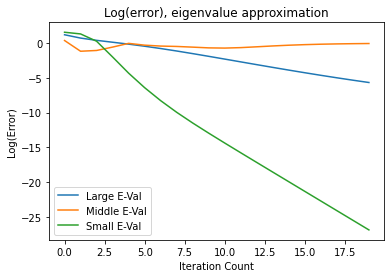

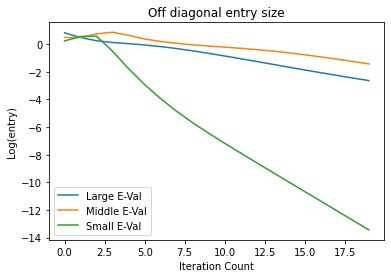

In [11]:

Aiter= np.copy(H);
for i in range(iterations):
    # Perform 1 iteration of QR without shifts, and store the result for plotting
    
    Aiter = QRnoShifts(Aiter[0],1);
    
    # Store current eigenvalue approximation at this iteration, and the largest corresponding off-diagonal
    LargeEval[i] = np.diag(Aiter[0])[0];
    OffDiagLarge[i] = np.diag(Aiter[0],-1)[0];
    
    MiddleEval[i] = np.diag(Aiter[0])[5];
    OffDiagMiddle[i] = np.diag(Aiter[0],-1)[4]
    
    
    SmallEval[i] = np.diag(Aiter[0])[9];
    OffDiagSmall[i] = np.diag(Aiter[0],-1)[8]
    
pl.figure()    
pl.plot(np.log(np.abs(LargeEval-TrueLarge)));
pl.plot(np.log(np.abs(MiddleEval-TrueMiddle)));
pl.plot(np.log(np.abs(SmallEval-TrueSmall)));
pl.title('Log(error), eigenvalue approximation');
pl.legend(['Large E-Val','Middle E-Val','Small E-Val']);
pl.xlabel('Iteration Count');
pl.ylabel('Log(Error)');

pl.figure()
pl.title('Off diagonal entry size');
pl.xlabel('Iteration Count');
pl.ylabel('Log(entry)');
pl.plot(np.log(np.abs(OffDiagLarge)));
pl.plot(np.log(np.abs(OffDiagMiddle)));
pl.plot(np.log(np.abs(OffDiagSmall)));
pl.legend(['Large E-Val','Middle E-Val','Small E-Val']);

We see several interesting things. 
- As expected, convergence in the smallest eigenvalue (here the $n$th-eigenvalue, $A_{n,n}$) is the fastest.
- However, we also observe convergence in other eigenvalues, which is not always the case for QR without shifts. Furhtermore, the convergence is much slower than that of the target eigenvalue.
- In log scale, we observe straight lines, the expected linear convergence.

## QR with Rayleigh Quotient Shift, and results
Now we move onto QR with the Rayleigh Quotient shift. Note, we leave the code uncommented, as it is precisely the same code as above with only the QR method changed.

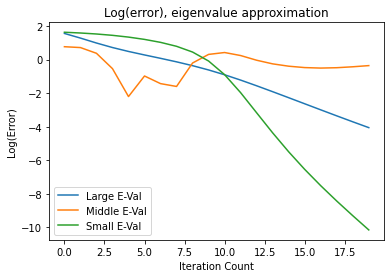

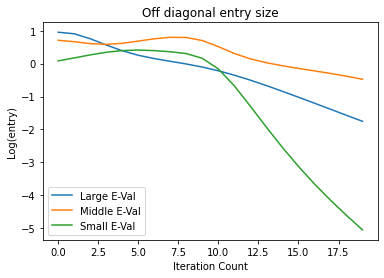

In [12]:
Aiter= np.copy(H);

for i in range(iterations):
    Aiter = QRRayleigh(Aiter[0],1);
    LargeEval[i] = np.diag(Aiter[0])[0];
    OffDiagLarge[i] = np.diag(Aiter[0],-1)[0];
    
    MiddleEval[i] = np.diag(Aiter[0])[5];
    OffDiagMiddle[i] = np.diag(Aiter[0],-1)[4]
    
    
    SmallEval[i] = np.diag(Aiter[0])[9];
    OffDiagSmall[i] = np.diag(Aiter[0],-1)[8]
    
pl.plot(np.log(np.abs(LargeEval-TrueLarge)));
pl.plot(np.log(np.abs(MiddleEval-TrueMiddle)));
pl.plot(np.log(np.abs(SmallEval-TrueSmall)));
pl.title('Log(error), eigenvalue approximation');
pl.legend(['Large E-Val','Middle E-Val','Small E-Val']);
pl.xlabel('Iteration Count');
pl.ylabel('Log(Error)');

pl.figure()
pl.title('Off diagonal entry size');
pl.xlabel('Iteration Count');
pl.ylabel('Log(entry)');
pl.plot(np.log(np.abs(OffDiagLarge)));
pl.plot(np.log(np.abs(OffDiagMiddle)));
pl.plot(np.log(np.abs(OffDiagSmall)));

pl.legend(['Large E-Val','Middle E-Val','Small E-Val']);
    

Here, we observe the expected cubic convergnce in the target eigenvalue. Here however, the other eigenvalues (and off-diagonal entries) have much less monotonic behaivor compare to QR without shifts

## QR with Wilkinson Shift
Finally, we compare the wilkinson shift.

<ipython-input-13-b5b4296c3a85>:28: RuntimeWarning: divide by zero encountered in log
  pl.plot(np.log(np.abs(OffDiagLarge)));


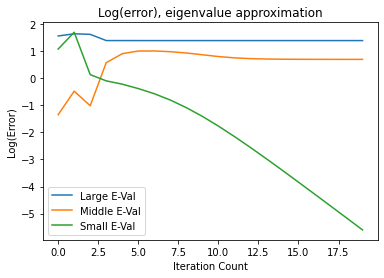

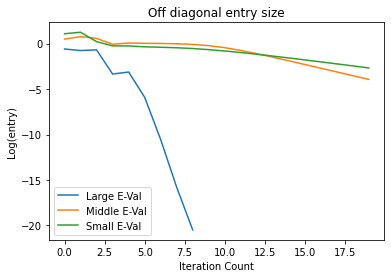

In [13]:

Aiter= np.copy(H);

for i in range(iterations):
    
    Aiter = QRWilkinson(Aiter[0],1);
    LargeEval[i] = np.diag(Aiter[0])[9];
    OffDiagLarge[i] = np.diag(Aiter[0],-1)[8];
    
    MiddleEval[i] = np.diag(Aiter[0])[5];
    OffDiagMiddle[i] = np.diag(Aiter[0],-1)[4]
    
    
    SmallEval[i] = np.diag(Aiter[0])[0];
    OffDiagSmall[i] = np.diag(Aiter[0],-1)[0]
    
pl.plot(np.log(np.abs(LargeEval-TrueLarge)));
pl.plot(np.log(np.abs(MiddleEval-TrueMiddle)));
pl.plot(np.log(np.abs(SmallEval-TrueSmall)));
pl.title('Log(error), eigenvalue approximation');
pl.legend(['Large E-Val','Middle E-Val','Small E-Val']);
pl.xlabel('Iteration Count');
pl.ylabel('Log(Error)');

pl.figure()
pl.title('Off diagonal entry size');
pl.xlabel('Iteration Count');
pl.ylabel('Log(entry)');
pl.plot(np.log(np.abs(OffDiagLarge)));
pl.plot(np.log(np.abs(OffDiagMiddle)));
pl.plot(np.log(np.abs(OffDiagSmall)));
pl.legend(['Large E-Val','Middle E-Val','Small E-Val']);
    

Here we observe remarkable fast convergence - so fast in fact that we have numerically zero off-diagonal entries as early as iteraion $7$ (and thus the $log(0)$ error thrown by python.) This is to be expected of wilkinson, as it converges cubically for all initial conditions. interestingly, the off diagonal of all entries decreases rather quickly.

# Part 6: Some interesting Cases.
Here, we try several interesting case. Let us consider the matrix $A\in \mathbb{R}^{3 \times 3}$ with eigenvalues
$$ \text{diag}(\Lambda) = \{1,-1,2,-2\},$$
There no eigenvalue gap in absolute value. let us see what we observe:

In [14]:
# Basic Size of matrix, number of iterations
n=4;
iterations = 20;

# Things to plot: eigenvalues and off diagonal entries, 
LargeEval = np.zeros(iterations);
TrueLarge = np.ones(iterations)*-2;
OffDiagLarge = np.zeros(iterations);

# Set seed
np.random.seed(150);

# Generate A
Q = orthogonalRandom(n);
D = np.diag([1,-1,2,-2]);
Qt = np.transpose(Q[0]);

# Factor A into Hessenberg form. here we note H is tridiagonal as it is symettric.
A = np.matmul(np.matmul(Qt,D),Q);
H =HessenbergFactorize(A[0]);

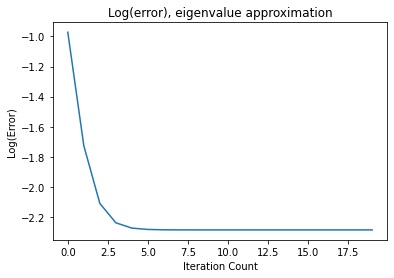

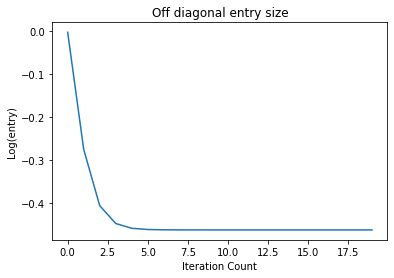

In [15]:
Aiter= np.copy(H);
for i in range(iterations):
    # Perform 1 iteration of QR without shifts, and store the result for plotting
    
    Aiter = QRnoShifts(Aiter[0],1);
    
    # Store current eigenvalue approximation at this iteration, and the largest corresponding off-diagonal
    LargeEval[i] = np.diag(Aiter[0])[0];
    OffDiagLarge[i] = np.diag(Aiter[0],-1)[0];
    
    
pl.figure()    
pl.plot(np.log(np.abs(LargeEval-TrueLarge)));
pl.title('Log(error), eigenvalue approximation');
pl.xlabel('Iteration Count');
pl.ylabel('Log(Error)');

pl.figure()
pl.title('Off diagonal entry size');
pl.xlabel('Iteration Count');
pl.ylabel('Log(entry)');
pl.plot(np.log(np.abs(OffDiagLarge)));

The QR algorithm with shifts here does in fact converge! However, if we make any eigenvalue have mulplicity (e.g. make $-2$ and eiganvalue instead of $2$;QR completely fails to converge. The same is true of singular matrices. For example if $\text{diag}(\Lambda) = \{1,-1,-2,-2\},$ we observe that the algorithm fails; here numerically via division by zero.

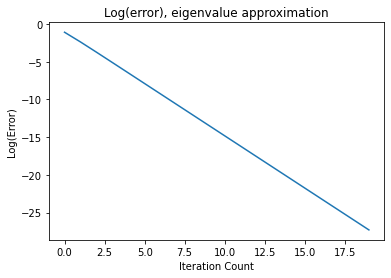

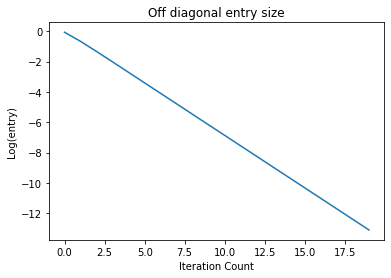

In [16]:

Q = orthogonalRandom(4);
D = np.diag([1,-1,-2,-2]);
Qt = np.transpose(Q[0]);

# Factor A into Hessenberg form. here we note H is tridiagonal as it is symettric.
A = np.matmul(np.matmul(Qt,D),Q);
H =HessenbergFactorize(A[0]);Aiter= np.copy(H);

for i in range(iterations):
    # Perform 1 iteration of QR without shifts, and store the result for plotting
    
    Aiter = QRnoShifts(Aiter[0],1);
    
    # Store current eigenvalue approximation at this iteration, and the largest corresponding off-diagonal
    LargeEval[i] = np.diag(Aiter[0])[0];
    OffDiagLarge[i] = np.diag(Aiter[0],-1)[0];
    
    
pl.figure()    
pl.plot(np.log(np.abs(LargeEval-TrueLarge)));
pl.title('Log(error), eigenvalue approximation');
pl.xlabel('Iteration Count');
pl.ylabel('Log(Error)');

pl.figure()
pl.title('Off diagonal entry size');
pl.xlabel('Iteration Count');
pl.ylabel('Log(entry)');
pl.plot(np.log(np.abs(OffDiagLarge)));


Other interesting examples are eigenvalues numericall close to zero (numericaly close to singular $A$). As we've seen above, QR breaks in this case. However, shifts perform moderately well in this setting. Consider eigenvalues of $A$ as $\{1,2,10^{-10}\}.$ Here with shifting, we still have rapid convergence!

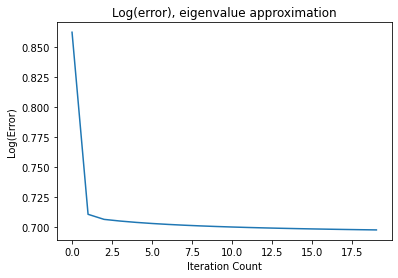

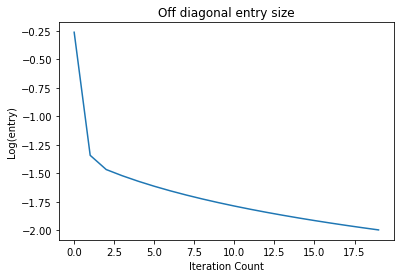

In [17]:
Q = orthogonalRandom(3);
D = np.diag([1,2,10**-10]);
Qt = np.transpose(Q[0]);

# Factor A into Hessenberg form. here we note H is tridiagonal as it is symettric.
A = np.matmul(np.matmul(Qt,D),Q);
H =HessenbergFactorize(A[0]);Aiter= np.copy(H);

for i in range(iterations):
    # Perform 1 iteration of QR without shifts, and store the result for plotting
    
    Aiter = QRWilkinson(Aiter[0],1);
    
    # Store current eigenvalue approximation at this iteration, and the largest corresponding off-diagonal
    LargeEval[i] = np.diag(Aiter[0])[0];
    OffDiagLarge[i] = np.diag(Aiter[0],-1)[0];
    
    
pl.figure()    
pl.plot(np.log(np.abs(LargeEval-TrueLarge)));
pl.title('Log(error), eigenvalue approximation');
pl.xlabel('Iteration Count');
pl.ylabel('Log(Error)');

pl.figure()
pl.title('Off diagonal entry size');
pl.xlabel('Iteration Count');
pl.ylabel('Log(entry)');
pl.plot(np.log(np.abs(OffDiagLarge)));

We conclude our experiments here. Of course, there is an endless number of experiements one could perform, but we move on for brevity to the very interesting case of cropping.

# Part 7:  Adding Cropping
Now, we add cropping to this setup. That is, when the last off diagonal entry is smaller is smaller than some tolerance,
$$ A_{n,n-1} < tol = 10^{-10}$$
we delete the last row and column of $A$, and continue running the QR algorithm. This is meant to approximate each eigenvalue of $A$ in turn, moving to the next eigenvalue when the off diagonal is sufficiently small (i.e. diagonalizing $A$). We will implement this as a large outer loop, and test for each version of the QR algorithm. The, we shall plot and discuss the number of iterations, convergence, and so on. Note that as we delete rows and columns, the size of the matrix will change, as will the eigenvalue we are approximating.

To avoid confusion, we plot for the $k$-th eigenvalue only the iterations performed after deleting the $k+1$st row and column. That is, we only plot the *additional* work done of computing this eigenvalue. We begin with the QR algorithm without shifts.

Converged on running total iteration number 33 for eigenvalue 1
Converged on running total iteration number 64 for eigenvalue 2
Converged on running total iteration number 84 for eigenvalue 3
Converged on running total iteration number 111 for eigenvalue 4
Converged on running total iteration number 138 for eigenvalue 5
Converged on running total iteration number 161 for eigenvalue 6
Converged on running total iteration number 171 for eigenvalue 7
Converged on running total iteration number 218 for eigenvalue 8
Converged on running total iteration number 219 for eigenvalue 9


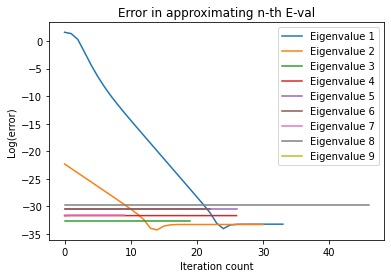

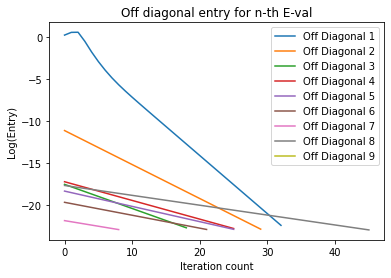

In [18]:
# Basic Size of matrix, number of iterations
n=10;
iterations = 20;

# Set seed
np.random.seed(150);

# Generate A
Q = orthogonalRandom(n);
D = np.diag(range(1,n+1,1));
Qt = np.transpose(Q[0]);

# Factor A into Hessenberg form. here we note H is tridiagonal as it is symettric.
A = np.matmul(np.matmul(Qt,D),Q);
H =HessenbergFactorize(A[0]);

Aiter = np.copy(H);
currentSize = n;
tol = 10**(-10);
evals = np.zeros(n);
iteration =0;
currentEval = 1;
error = [];
offDiag = [];

while(currentSize >1): 
    # Iterate while we do note have a singleton
    # Perform QR
    Aiter = QRnoShifts(Aiter[0],1);
    
    # Append plotting quantities of interest. These are variable length, so in lists.
    error.append(Aiter[0][currentSize-1,currentSize-1] - currentEval);
    offDiag.append(np.abs(Aiter[0][currentSize-2,currentSize-1]));
    
    if(np.abs(Aiter[0][currentSize-2,currentSize-1]) < tol):
        # If off diagonal is below tolerance, delete last row and column of current matrix
        # Store the corresponding eigenvalue.
        evals[currentSize-1] = Aiter[0][currentSize-1,currentSize-1];
        Aiter[0] =np.array(Aiter[0][0:currentSize-1,0:currentSize-1]);
        currentSize = currentSize-1;
        
        # Print statements for ease of viewing
        print('Converged on running total iteration number',iteration,'for eigenvalue',currentEval);
        currentEval = currentEval +1;
        
        #Plot Error
        pl.figure(1);
        error = np.array(error);
        pl.plot(np.log(np.abs(error)));
        error = [];
        
        pl.figure(2);
        # Avoid division by zero, we know last element of the off-diagonal is below tolerance.
        offDiag.pop();
        
        # Plot off-diagonal entries.
        offDiag = np.array(offDiag);
        pl.plot(np.log(np.abs(offDiag)));
        offDiag = [];
        
    iteration = iteration+1;
    
evals[0] = Aiter[0];
pl.figure(1)
pl.legend(['Eigenvalue 1','Eigenvalue 2','Eigenvalue 3','Eigenvalue 4','Eigenvalue 5','Eigenvalue 6','Eigenvalue 7','Eigenvalue 8','Eigenvalue 9','Eigenvalue 10'])
pl.xlabel('Iteration count');
pl.ylabel('Log(error)');
pl.title('Error in approximating n-th E-val');
pl.figure(2)
pl.legend(['Off Diagonal 1','Off Diagonal 2','Off Diagonal 3','Off Diagonal 4','Off Diagonal 5','Off Diagonal 6','Off Diagonal 7','Off Diagonal 8','Off Diagonal 9','Off Diagonal 10'])
pl.xlabel('Iteration count');
pl.ylabel('Log(Entry)');
pl.title('Off diagonal entry for n-th E-val');

Here, we can make several observations:
- Computing the first eigenvalue (here exactly 1, the smallest eigenvalue) take the most iterations, as we should expect.
- The off diagonal entries are monotonically decreasing per iteration; meaning we are converging!
- We actually have a very good approximation to later eigenvalues, *even when* the off diagonal is relatively large. One could speculate a method that does fewer iterations and has reasonable accuracy, trading off accuracy for speed.
- As we move to larger eigenvalues (and smaller and smaller submatrices) we converge fast - which is intuitively sensible!
- Keep in mind the total number of iterations: here 200. We will see the wilkinsion shift vastly outperforms this later.

Now, we repeat this experiment for the QR with shifts variants. For brevity; comment at the end of both of the following blocks of code, as they are exactly the same as above simply with the corresponsing QR method.

Converged on running total iteration number 64 for eigenvalue 1
Converged on running total iteration number 105 for eigenvalue 2
Converged on running total iteration number 128 for eigenvalue 3
Converged on running total iteration number 167 for eigenvalue 4
Converged on running total iteration number 205 for eigenvalue 5
Converged on running total iteration number 236 for eigenvalue 6
Converged on running total iteration number 242 for eigenvalue 7
Converged on running total iteration number 322 for eigenvalue 8
Converged on running total iteration number 323 for eigenvalue 9


<ipython-input-19-0cb8af0f42c1>:34: RuntimeWarning: divide by zero encountered in log
  pl.plot(np.log(np.abs(error)));


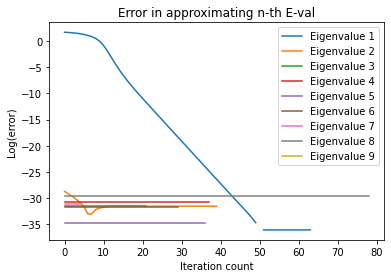

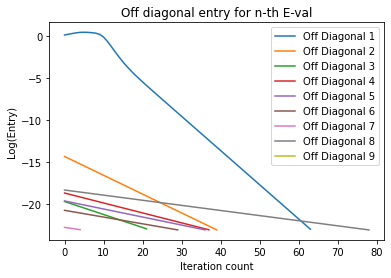

In [19]:
Aiter = np.copy(H);
currentSize = n;
tol = 10**(-10);
evals = np.zeros(n);
iteration =0;
currentEval = 1;
error = [];
offDiag = [];

while(currentSize >1): 
    # Iterate while we do note have a singleton
    # Perform QR - Rayleigh
    Aiter = QRRayleigh(Aiter[0],1);
    
    # Append plotting quantities of interest. These are variable length, so in lists.
    error.append(Aiter[0][currentSize-1,currentSize-1] - currentEval);
    offDiag.append(np.abs(Aiter[0][currentSize-2,currentSize-1]));
    
    if(np.abs(Aiter[0][currentSize-2,currentSize-1]) < tol):
        # If off diagonal is below tolerance, delete last row and column of current matrix
        # Store the corresponding eigenvalue.
        evals[currentSize-1] = Aiter[0][currentSize-1,currentSize-1];
        Aiter[0] =np.array(Aiter[0][0:currentSize-1,0:currentSize-1]);
        currentSize = currentSize-1;
        
        # Print statements for ease of viewing
        print('Converged on running total iteration number',iteration,'for eigenvalue',currentEval);
        currentEval = currentEval +1;
        
        #Plot Error
        pl.figure(1);
        error.pop();
        error = np.array(error);
        pl.plot(np.log(np.abs(error)));
        error = [];
        
        pl.figure(2);
        # Avoid division by zero, we know last element of the off-diagonal is below tolerance.
        offDiag.pop();
        
        # Plot off-diagonal entries.
        offDiag = np.array(offDiag);
        pl.plot(np.log(np.abs(offDiag)));
        offDiag = [];
        
    iteration = iteration+1;
    
evals[0] = Aiter[0];
pl.figure(1)
pl.legend(['Eigenvalue 1','Eigenvalue 2','Eigenvalue 3','Eigenvalue 4','Eigenvalue 5','Eigenvalue 6','Eigenvalue 7','Eigenvalue 8','Eigenvalue 9','Eigenvalue 10'])
pl.xlabel('Iteration count');
pl.ylabel('Log(error)');
pl.title('Error in approximating n-th E-val');
pl.figure(2)
pl.legend(['Off Diagonal 1','Off Diagonal 2','Off Diagonal 3','Off Diagonal 4','Off Diagonal 5','Off Diagonal 6','Off Diagonal 7','Off Diagonal 8','Off Diagonal 9','Off Diagonal 10'])
pl.xlabel('Iteration count');
pl.ylabel('Log(Entry)');
pl.title('Off diagonal entry for n-th E-val');

Converged on running total iteration number 9 for eigenvalue 1
Converged on running total iteration number 18 for eigenvalue 2
Converged on running total iteration number 29 for eigenvalue 3
Converged on running total iteration number 45 for eigenvalue 4
Converged on running total iteration number 47 for eigenvalue 5
Converged on running total iteration number 51 for eigenvalue 6
Converged on running total iteration number 53 for eigenvalue 7
Converged on running total iteration number 55 for eigenvalue 8
Converged on running total iteration number 56 for eigenvalue 9


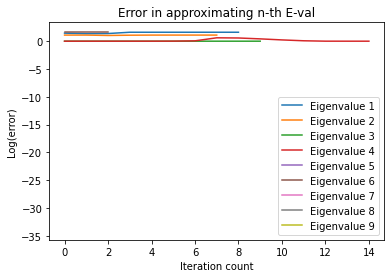

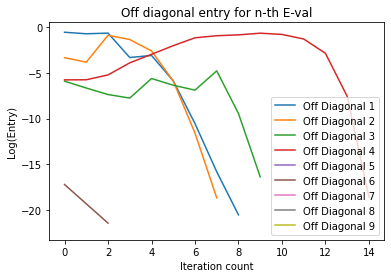

In [20]:
Aiter = np.copy(H);
currentSize = n;
tol = 10**(-10);
evals = np.zeros(n);
iteration =0;
currentEval = 1;
error = [];
offDiag = [];

while(currentSize >1): 
    # Iterate while we do note have a singleton
    # Perform QR - Rayleigh
    Aiter = QRWilkinson(Aiter[0],1);
    
    # Append plotting quantities of interest. These are variable length, so in lists.
    error.append(Aiter[0][currentSize-1,currentSize-1] - currentEval);
    offDiag.append(np.abs(Aiter[0][currentSize-2,currentSize-1]));
    
    if(np.abs(Aiter[0][currentSize-2,currentSize-1]) < tol):
        # If off diagonal is below tolerance, delete last row and column of current matrix
        # Store the corresponding eigenvalue.
        evals[currentSize-1] = Aiter[0][currentSize-1,currentSize-1];
        Aiter[0] =np.array(Aiter[0][0:currentSize-1,0:currentSize-1]);
        currentSize = currentSize-1;
        
        # Print statements for ease of viewing
        print('Converged on running total iteration number',iteration,'for eigenvalue',currentEval);
        currentEval = currentEval +1;
        
        #Plot Error
        pl.figure(1);
        error.pop();
        error = np.array(error);
        pl.plot(np.log(np.abs(error)));
        error = [];
        
        pl.figure(2);
        # Avoid division by zero, we know last element of the off-diagonal is below tolerance.
        offDiag.pop();
        
        # Plot off-diagonal entries.
        offDiag = np.array(offDiag);
        pl.plot(np.log(np.abs(offDiag)));
        offDiag = [];
        
    iteration = iteration+1;
    
evals[0] = Aiter[0];
pl.figure(1)
pl.legend(['Eigenvalue 1','Eigenvalue 2','Eigenvalue 3','Eigenvalue 4','Eigenvalue 5','Eigenvalue 6','Eigenvalue 7','Eigenvalue 8','Eigenvalue 9','Eigenvalue 10'])
pl.xlabel('Iteration count');
pl.ylabel('Log(error)');
pl.title('Error in approximating n-th E-val');
pl.figure(2)
pl.legend(['Off Diagonal 1','Off Diagonal 2','Off Diagonal 3','Off Diagonal 4','Off Diagonal 5','Off Diagonal 6','Off Diagonal 7','Off Diagonal 8','Off Diagonal 9','Off Diagonal 10'])
pl.xlabel('Iteration count');
pl.ylabel('Log(Entry)');
pl.title('Off diagonal entry for n-th E-val');

For both the wilkinsion and rayleigh quotient shift, we see remarkably fast convergence. This is to be expected of cubic methods. For example, the Wilkinson shift requires only 56 iterations to compute all the eigenvalues, compared to the nearly 300 of QR without shifts.

## To some interesting examples
Finally, we conclde with some examples; numerically singular eigenvalues, repeated eigenvalues, and large eigenvalues. We will not test all these cases on all three algorithms, simply as the length of such experiment is prohibively long. Instead we show only some interesting cases. Let us first consider $A$ with eigenvalues close to zero. we run the same experiment as above, but also print the resulting eigenvalues to examine if we have set anything to zero spuriosly.

Converged on running total iteration number 1 for eigenvalue 1
Converged on running total iteration number 35 for eigenvalue 2
Converged on running total iteration number 58 for eigenvalue 3
Converged on running total iteration number 83 for eigenvalue 4
[ 4.00000000e+00  3.00000000e+00  2.00000000e+00  1.00000000e+00
 -9.99999986e-09]


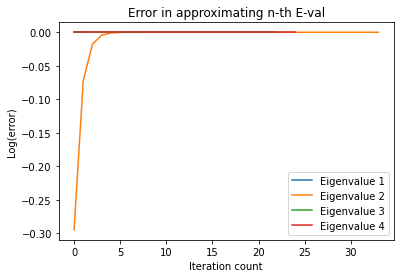

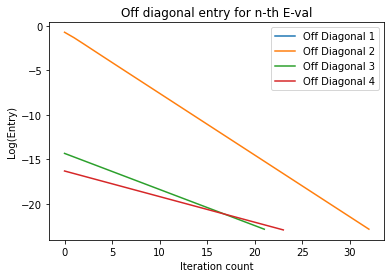

In [21]:
# Basic Size of matrix, number of iterations
n=5;
iterations = 20;

# Set seed
np.random.seed(150);

# Generate A
Q = orthogonalRandom(n);
D = np.diag([-10**-8,1,2,3,4]);
Qt = np.transpose(Q[0]);

# Factor A into Hessenberg form. here we note H is tridiagonal as it is symettric.
A = np.matmul(np.matmul(Qt,D),Q);
H =HessenbergFactorize(A[0]);

Aiter = np.copy(H);
currentSize = n;
tol = 10**(-10);
evals = np.zeros(n);
iteration =0;
currentEval = 1;
error = [];
offDiag = [];

while(currentSize >1): 
    # Iterate while we do note have a singleton
    # Perform QR
    Aiter = QRnoShifts(Aiter[0],1);
    
    # Append plotting quantities of interest. These are variable length, so in lists.
    error.append(Aiter[0][currentSize-1,currentSize-1] - currentEval);
    offDiag.append(np.abs(Aiter[0][currentSize-2,currentSize-1]));
    
    if(np.abs(Aiter[0][currentSize-2,currentSize-1]) < tol):
        # If off diagonal is below tolerance, delete last row and column of current matrix
        # Store the corresponding eigenvalue.
        evals[currentSize-1] = Aiter[0][currentSize-1,currentSize-1];
        Aiter[0] =np.array(Aiter[0][0:currentSize-1,0:currentSize-1]);
        currentSize = currentSize-1;
        
        # Print statements for ease of viewing
        print('Converged on running total iteration number',iteration,'for eigenvalue',currentEval);
        currentEval = currentEval +1;
        
        #Plot Error
        pl.figure(1);
        error = np.array(error);
        pl.plot(np.log(np.abs(error)));
        error = [];
        
        pl.figure(2);
        # Avoid division by zero, we know last element of the off-diagonal is below tolerance.
        offDiag.pop();
        
        # Plot off-diagonal entries.
        offDiag = np.array(offDiag);
        pl.plot(np.log(np.abs(offDiag)));
        offDiag = [];
        
    iteration = iteration+1;
    
evals[0] = Aiter[0];
pl.figure(1)
pl.legend(['Eigenvalue 1','Eigenvalue 2','Eigenvalue 3','Eigenvalue 4']);
pl.xlabel('Iteration count');
pl.ylabel('Log(error)');
pl.title('Error in approximating n-th E-val');
pl.figure(2)
pl.legend(['Off Diagonal 1','Off Diagonal 2','Off Diagonal 3','Off Diagonal 4']);
pl.xlabel('Iteration count');
pl.ylabel('Log(Entry)');
pl.title('Off diagonal entry for n-th E-val');
print(evals)

Perhaps suprisingly, our eigenvalue of size $10^-8$ is in fact recovered! Another interesting experiment is with repeated eigenvalues. However, we do not perform this experiment here as **this does not converge**; in fact resulting in an infinite loop in which the off diagonal entries are never small enough to crop the matrix - regardless of the QR method used. Another interesting case we try here is extremely large eigenvalues. Here we use wilkinson shifts.

Converged on running total iteration number 8 for eigenvalue 1
Converged on running total iteration number 10 for eigenvalue 2
Converged on running total iteration number 20 for eigenvalue 3
Converged on running total iteration number 21 for eigenvalue 4
[1.e+05 1.e+01 4.e+00 3.e+00 2.e+00]


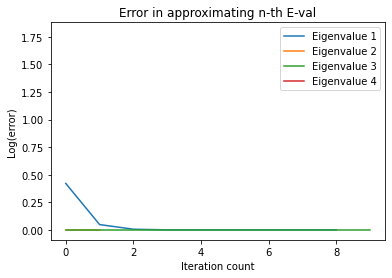

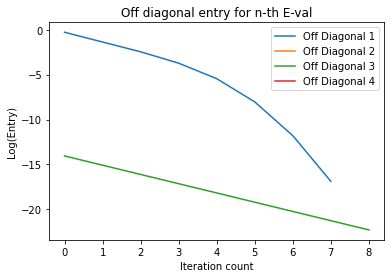

In [22]:
# Basic Size of matrix, number of iterations
n=5;
iterations = 20;

# Set seed
np.random.seed(150);

# Generate A
Q = orthogonalRandom(n);
D = np.diag([10,10**5,2,3,4]);
Qt = np.transpose(Q[0]);

# Factor A into Hessenberg form. here we note H is tridiagonal as it is symettric.
A = np.matmul(np.matmul(Qt,D),Q);
H =HessenbergFactorize(A[0]);

Aiter = np.copy(H);
currentSize = n;
tol = 10**(-10);
evals = np.zeros(n);
iteration =0;
currentEval = 1;
error = [];
offDiag = [];

while(currentSize >1): 
    # Iterate while we do note have a singleton
    # Perform QR
    Aiter = QRWilkinson(Aiter[0],1);
    
    # Append plotting quantities of interest. These are variable length, so in lists.
    error.append(Aiter[0][currentSize-1,currentSize-1] - currentEval);
    offDiag.append(np.abs(Aiter[0][currentSize-2,currentSize-1]));
    
    if(np.abs(Aiter[0][currentSize-2,currentSize-1]) < tol):
        # If off diagonal is below tolerance, delete last row and column of current matrix
        # Store the corresponding eigenvalue.
        evals[currentSize-1] = Aiter[0][currentSize-1,currentSize-1];
        Aiter[0] =np.array(Aiter[0][0:currentSize-1,0:currentSize-1]);
        currentSize = currentSize-1;
        
        # Print statements for ease of viewing
        print('Converged on running total iteration number',iteration,'for eigenvalue',currentEval);
        currentEval = currentEval +1;
        
        #Plot Error
        pl.figure(1);
        error = np.array(error);
        pl.plot(np.log(np.abs(error)));
        error = [];
        
        pl.figure(2);
        # Avoid division by zero, we know last element of the off-diagonal is below tolerance.
        offDiag.pop();
        
        # Plot off-diagonal entries.
        offDiag = np.array(offDiag);
        pl.plot(np.log(np.abs(offDiag)));
        offDiag = [];
        
    iteration = iteration+1;
    
evals[0] = Aiter[0];
pl.figure(1)
pl.legend(['Eigenvalue 1','Eigenvalue 2','Eigenvalue 3','Eigenvalue 4']);
pl.xlabel('Iteration count');
pl.ylabel('Log(error)');
pl.title('Error in approximating n-th E-val');
pl.figure(2)
pl.legend(['Off Diagonal 1','Off Diagonal 2','Off Diagonal 3','Off Diagonal 4']);
pl.xlabel('Iteration count');
pl.ylabel('Log(Entry)');
pl.title('Off diagonal entry for n-th E-val');
print(evals)

Here again the performance is suprisingly okay, with us recovering $10^5$ as an eigenvalue. However, making this any larger (e.g. making 10^8 an eigenvalue), results in poor/slow/no convergence. Thus, large eigenvalues also pose a problem for these computations.